# Unit 3, Exercise 1: Banknote Authentication

In this exercise, we are applying logistic regression to a banknote authentication dataset to distinguish between genuine and forged bank notes.


**The dataset consists of 1372 examples and 4 features for binary classification.** The features are 

1. variance of a wavelet-transformed image (continuous) 
2. skewness of a wavelet-transformed image (continuous) 
3. kurtosis of a wavelet-transformed image (continuous) 
4. entropy of the image (continuous) 

(You can fine more details about this dataset at [https://archive.ics.uci.edu/ml/datasets/banknote+authentication](https://archive.ics.uci.edu/ml/datasets/banknote+authentication).)


In essence, these four features represent features that were manually extracted from image data. Note that you do not need the details of these features for this exercise. 

However, you are encouraged to explore the dataset further, e.g., by plotting the features, looking at the value ranges, and so forth. (We will skip these steps for brevity in this exercise)

Most of the code should look familiar to you since it is based on the logistic regression code from Unit 3.6.

## 1) Installing Libraries

You likely already have all libraries installed and don't need to do anything here.

In [4]:
# !conda install numpy pandas matplotlib --yes

In [5]:
# !pip install torch

In [6]:
# !conda install watermark

In [7]:
%load_ext watermark
%watermark -v -p numpy,pandas,matplotlib,torch

Python implementation: CPython
Python version       : 3.13.1
IPython version      : 8.30.0

numpy     : 2.2.0
pandas    : 2.2.3
matplotlib: 3.10.0
torch     : 2.6.0



## 2) Loading the Dataset

We are using the familiar `read_csv` function from pandas to load the dataset:

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv("data_banknote_authentication.txt", header=None)
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [10]:
X_features = df[[0, 1, 2, 3]].values
y_labels = df[4].values

Number of examples and features:

In [11]:
X_features.shape

(1372, 4)

It is usually a good idea to look at the label distribution:

In [12]:
import numpy as np

np.bincount(y_labels)

array([762, 610])

## 3) Defining a DataLoader

The `DataLoader` code is the same code we used in Unit 3.6:

In [13]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]

We will be using 80% of the data for training, 20% of the data for validation. In a real-project, we would also have a separate dataset for the final test set (in this case, we do not have an explicit test set).

In [14]:
train_size = int(X_features.shape[0]*0.80)
train_size

1097

In [15]:
val_size = X_features.shape[0] - train_size
val_size

275

Using `torch.utils.data.random_split`, we generate the training and validation sets along with the respective data loaders:

In [16]:
import torch

dataset = MyDataset(X_features, y_labels)

torch.manual_seed(1)
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    dataset=train_set,
    batch_size=10,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=10,
    shuffle=False,
)

## 4) Implementing the model

Here, we are resusing the same model code we used in Unit 3.6:

In [17]:
import torch

class LogisticRegression(torch.nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

## 5) The training loop

In this section, we are using the training loop from Unit 3.6. It's the exact same code except for some small modification: We added the line `if not batch_idx % 20` to only print the loss for every 20th batch (to reduce the number of output lines).

<font color='red'>YOUR TASK is to find a good learning rate and epoch number so that you achieve a training and validation performance of at least 98%.</font>

In [18]:
import torch.nn.functional as F

learning_rate = 0.01
num_epochs = 50

torch.manual_seed(1)
model = LogisticRegression(num_features=4)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) ## FILL IN VALUE

num_epochs = num_epochs  ## FILL IN VALUE
stop_training = False
for epoch in range(num_epochs):
    
    model = model.train()
    for batch_idx, (features, class_labels) in enumerate(train_loader):

        probas = model(features)
        
        loss = F.binary_cross_entropy(probas, class_labels.view(probas.shape))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20: # log every 20th batch
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
                   f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
                   f' | Loss: {loss:.2f}')
        if loss < 0.01:
            print('Reached desired loss, stopping training.')
            stop_training = True
            break
    if stop_training:
        break
        

Epoch: 001/050 | Batch 000/110 | Loss: 1.30
Epoch: 001/050 | Batch 020/110 | Loss: 0.85
Epoch: 001/050 | Batch 040/110 | Loss: 0.66
Epoch: 001/050 | Batch 060/110 | Loss: 0.37
Epoch: 001/050 | Batch 080/110 | Loss: 0.28
Epoch: 001/050 | Batch 100/110 | Loss: 0.29
Epoch: 002/050 | Batch 000/110 | Loss: 0.39
Epoch: 002/050 | Batch 020/110 | Loss: 0.22
Epoch: 002/050 | Batch 040/110 | Loss: 0.35
Epoch: 002/050 | Batch 060/110 | Loss: 0.19
Epoch: 002/050 | Batch 080/110 | Loss: 0.19
Epoch: 002/050 | Batch 100/110 | Loss: 0.18
Epoch: 003/050 | Batch 000/110 | Loss: 0.13
Epoch: 003/050 | Batch 020/110 | Loss: 0.28
Epoch: 003/050 | Batch 040/110 | Loss: 0.21
Epoch: 003/050 | Batch 060/110 | Loss: 0.37
Epoch: 003/050 | Batch 080/110 | Loss: 0.18
Epoch: 003/050 | Batch 100/110 | Loss: 0.14
Epoch: 004/050 | Batch 000/110 | Loss: 0.15
Epoch: 004/050 | Batch 020/110 | Loss: 0.07
Epoch: 004/050 | Batch 040/110 | Loss: 0.17
Epoch: 004/050 | Batch 060/110 | Loss: 0.16
Epoch: 004/050 | Batch 080/110 |

In [19]:
import torch
import torch.nn.functional as F

def train_logistic_model(model, train_loader, learning_rate=0.01, num_epochs=50):
    """
    Train a logistic regression model.
    
    Parameters:
    -----------
    model : torch.nn.Module
        The logistic regression model to train
    train_loader : torch.utils.data.DataLoader
        DataLoader containing the training data
    learning_rate : float, default=0.01
        Learning rate for the optimizer
    num_epochs : int, default=50
        Maximum number of epochs to train for
        
    Returns:
    --------
    int
        The epoch at which training stopped (either reached desired performance or completed all epochs)
    """
    torch.manual_seed(1)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    stop_training = False
    for epoch in range(num_epochs):
        
        model = model.train()
        for batch_idx, (features, class_labels) in enumerate(train_loader):

            probas = model(features)
            
            loss = F.binary_cross_entropy(probas, class_labels.view(probas.shape))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Logging
            if not batch_idx % 20:  # log every 20th batch
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
                      f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
                      f' | Loss: {loss:.2f}')
            
            if loss < 0.01:
                print('Reached desired loss, stopping training.')
                stop_training = True
                break
                
        if stop_training:
            break
    
    return epoch + 1  # Return the epoch number (1-indexed)

In [20]:
epochs = []
for lr in [lr/1000.0 for lr in range(1, 11)]:
    print(f'Learning rate: {lr}')
    model = LogisticRegression(num_features=4)
    epoch = train_logistic_model(model, train_loader, learning_rate=lr)
    epochs.append(epoch)
    print('\n')

Learning rate: 0.001
Epoch: 001/050 | Batch 000/110 | Loss: 0.95
Epoch: 001/050 | Batch 020/110 | Loss: 1.04
Epoch: 001/050 | Batch 040/110 | Loss: 1.06
Epoch: 001/050 | Batch 060/110 | Loss: 0.81
Epoch: 001/050 | Batch 080/110 | Loss: 0.99
Epoch: 001/050 | Batch 100/110 | Loss: 0.63
Epoch: 002/050 | Batch 000/110 | Loss: 0.55
Epoch: 002/050 | Batch 020/110 | Loss: 0.87
Epoch: 002/050 | Batch 040/110 | Loss: 0.68
Epoch: 002/050 | Batch 060/110 | Loss: 0.47
Epoch: 002/050 | Batch 080/110 | Loss: 0.59
Epoch: 002/050 | Batch 100/110 | Loss: 0.53
Epoch: 003/050 | Batch 000/110 | Loss: 0.69
Epoch: 003/050 | Batch 020/110 | Loss: 0.42
Epoch: 003/050 | Batch 040/110 | Loss: 0.51
Epoch: 003/050 | Batch 060/110 | Loss: 0.28
Epoch: 003/050 | Batch 080/110 | Loss: 0.56
Epoch: 003/050 | Batch 100/110 | Loss: 0.53
Epoch: 004/050 | Batch 000/110 | Loss: 0.42
Epoch: 004/050 | Batch 020/110 | Loss: 0.53
Epoch: 004/050 | Batch 040/110 | Loss: 0.38
Epoch: 004/050 | Batch 060/110 | Loss: 0.46
Epoch: 004/

In [23]:
lr_rates = [lr/1000.0 for lr in range(1, 11)]
print(epochs)
print(lr_rates)

[50, 35, 18, 18, 18, 18, 18, 11, 7, 7]
[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]


In [27]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def plot_lr_vs_epochs(epochs, lr_rates):
    """
    Plot learning rates versus epochs needed to reach convergence
    """
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(lr_rates, epochs, 'o-', linewidth=2, markersize=8, color='C0')
    plt.xlabel('Learning Rate')
    plt.ylabel('Epochs until Convergence')
    plt.title('Effect of Learning Rate on Convergence Speed')
    plt.grid(True)
    
     # Add annotations for each point
    for i, (lr, epoch) in enumerate(zip(lr_rates, epochs)):
         plt.annotate(f'({lr:.4f}, {epoch})', 
                      xy=(lr, epoch),
                      xytext=(5, 5),
                      textcoords='offset points')
    
     # Add annotation about loss rate threshold
    plt.annotate('Loss rate < 0.01', 
                 xy=(0.5, 0.95),
                 xytext=(0.5, 0.95),
                 xycoords='axes fraction',
                 ha='center',
                 va='top',
                 color='C0',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))    
    plt.tight_layout()
    plt.show()
    # Save the plot as a PNG file
    plt.savefig('lr_vs_epochs.png')

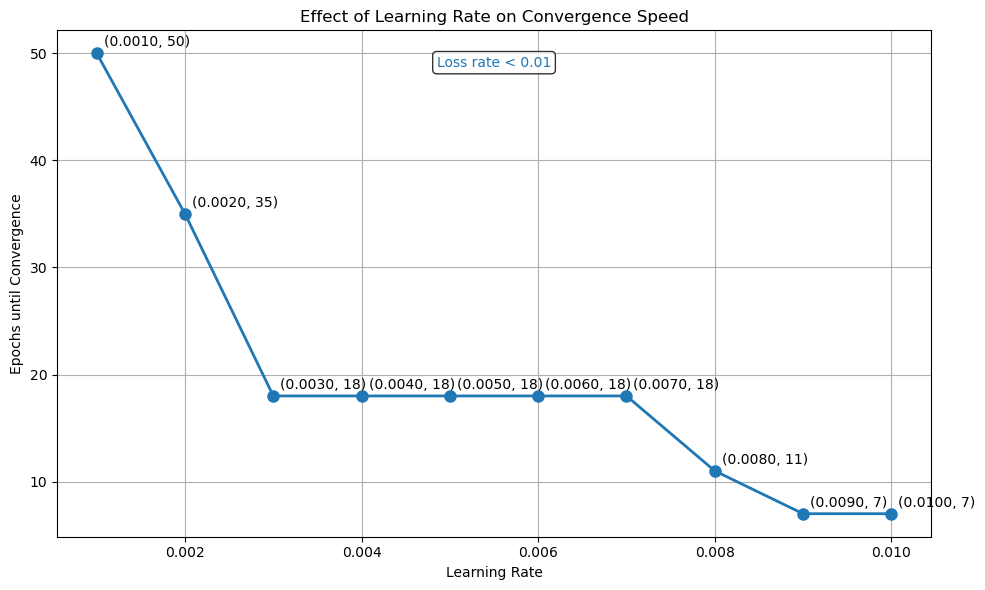

<Figure size 640x480 with 0 Axes>

In [28]:
plot_lr_vs_epochs(epochs, lr_rates)

## 6) Evaluating the results

Again, reusing the code from Unit 3.6, we will calculate the training and validation set accuracy.

In [30]:
def compute_accuracy(model, dataloader):

    model = model.eval()
    
    correct = 0.0
    total_examples = 0
    
    for idx, (features, class_labels) in enumerate(dataloader):
        
        with torch.no_grad():
            probas = model(features)
        
        pred = torch.where(probas > 0.5, 1, 0)
        lab = class_labels.view(pred.shape).to(pred.dtype)

        compare = lab == pred
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [31]:
train_acc = compute_accuracy(model, train_loader)
print(f"Training Accuracy: {train_acc*100:.2f}%")

Training Accuracy: 97.45%


<font color='red'>Notice that the code validation accuracy is not shown? It's part of the exercise to implement it :)</font>

In [ ]:
## YOUR CODE

In [32]:
val_acc = compute_accuracy(model, val_loader)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

Validation Accuracy: 97.09%
